In [1]:
import numpy as np
import pandas as pd

In [2]:
# df=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv")

In [3]:
# df.shape

In [176]:
import csv
import random

def reservoir_sampling(iterable, k, header=True):
    reservoir = []
    for i, item in enumerate(iterable):
        if i < k:
            reservoir.append(item)
        else:
            j = random.randint(0, i)
            if j < k:
                reservoir[j] = item
    return reservoir

# Open the input CSV file
with open(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv") as f:
    # Check if header line exists
    header = True
    first_line = f.readline()
    if not first_line.startswith('step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud'):
        header = False
        f.seek(0)  # Rewind file pointer to beginning

    # Sample from remaining lines
    sampled_lines = reservoir_sampling(f, k=2300000, header=header)

# Open the output CSV file and write the subsample to it
with open(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\sample1300000.csv", mode='w', newline='') as f:
    writer = csv.writer(f)
    if header:
        writer.writerow(first_line.strip().split(','))
    for line in sampled_lines:
        writer.writerow(line.strip().split(','))

In [177]:
# df_sample=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\sample.csv")

In [178]:
df_sample=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\sample1300000.csv")

In [179]:
df_sample = df_sample.reset_index(drop=True)

In [180]:
df_sample.shape

(2300000, 11)

In [181]:
# # Change the data type of column 'A' from float64 to float32
# df_sample['amount'] = df_sample['amount'].astype('float32')
# df_sample['oldbalanceOrg'] = df_sample['oldbalanceOrg'].astype('float32')
# df_sample['oldbalanceDest'] = df_sample['oldbalanceDest'].astype('float32')
# df_sample['newbalanceOrig'] = df_sample['newbalanceOrig'].astype('float32')
# df_sample['newbalanceDest'] = df_sample['newbalanceDest'].astype('float32')

In [182]:
# df_sample['step'] = df_sample['step'].astype('int32')
# df_sample['isFlaggedFraud'] = df_sample['isFlaggedFraud'].astype('int32') 
# df_sample['isFraud'] = df_sample['isFraud'].astype('int32') 

In [183]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['type'])
label
df_sample.drop("type", axis=1, inplace=True)
df_sample["type"] = label

In [184]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameDest'])
label
df_sample.drop("nameDest", axis=1, inplace=True)
df_sample["nameDest"] = label

In [185]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameOrig'])
label
df_sample.drop("nameOrig", axis=1, inplace=True)
df_sample["nameOrig"] = label

## Train-test split

In [186]:
from sklearn.model_selection import train_test_split

X = df_sample.drop('isFraud', axis=1)
# Separate the target variable
y = df_sample['isFraud']

# Print class distribution before split
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=2)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.998703
1    0.001297
Name: isFraud, dtype: float64
0    0.998702
1    0.001298
Name: isFraud, dtype: float64
0    0.998704
1    0.001296
Name: isFraud, dtype: float64


In [187]:
X_train.shape

(2070000, 10)

In [188]:
import numpy as np

# assuming y_train is a numpy array or a pandas series
counts = np.bincount(y_train)
print("Class 0 count:", counts[0])
print("Class 1 count:", counts[1])

Class 0 count: 2067314
Class 1 count: 2686


In [189]:
X_test.shape

(230000, 10)

## Class imbalance

In [190]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Upsampling via SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=0)

#Downsample via RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.4, random_state=0)

#Application of the resampling methods
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

In [191]:
import numpy as np

# assuming y_train is a numpy array or a pandas series
counts = np.bincount(y_resampled)
print("Class 0 count:", counts[0])
print("Class 1 count:", counts[1])

Class 0 count: 1033655
Class 1 count: 413462


In [192]:
X_resampled.shape

(1447117, 10)

## Tomeks

In [193]:
from imblearn.under_sampling import TomekLinks

#Resample using TomekLinks first
tomek_links = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_resampled, y_resampled)

In [194]:
import numpy as np

# assuming y_train is a numpy array or a pandas series
counts = np.bincount(y_train_resampled)
print("Class 0 count:", counts[0])
print("Class 1 count:", counts[1])

Class 0 count: 1033640
Class 1 count: 413462


In [195]:
X_train_resampled.shape

(1447102, 10)

## ENN

In [196]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection
# resample the output of TomekLinks using EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_resampled_new, y_train_resampled_new = enn.fit_resample(X_train_resampled, y_train_resampled)

In [197]:
import numpy as np

# assuming y_train is a numpy array or a pandas series
counts = np.bincount(y_train_resampled_new)
print("Class 0 count:", counts[0])
print("Class 1 count:", counts[1])

Class 0 count: 1024337
Class 1 count: 413462


## OSS

In [198]:
from imblearn.under_sampling import OneSidedSelection
# resample the output of EditedNearestNeighbours using One-Sided Selection
oss = OneSidedSelection(sampling_strategy='majority')
X_train_resampled_final, y_train_resampled_final = oss.fit_resample(X_train_resampled_new, y_train_resampled_new)

In [199]:
import numpy as np

counts = np.bincount(y_train_resampled_final)
print("Class 0 count:", counts[0])
print("Class 1 count:", counts[1])

Class 0 count: 1004498
Class 1 count: 413462


In [200]:
import numpy as np

# assuming y_train is a numpy array or a pandas series
counts = np.bincount(y_test)
print("Class 0 count:", counts[0])
print("Class 1 count:", counts[1])

Class 0 count: 229702
Class 1 count: 298


In [201]:
X_train_resampled_final.shape

(1417960, 10)

In [202]:
y_train_resampled_final.shape

(1417960,)

In [132]:
X_train_resampled_final.to_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\trainPRIOR.csv", index=False)
#X_test.to_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\test.csv", index=False)

## Outliers

In [203]:
import random
import numpy as np
from scipy import stats

random.seed(0)
# Specify columns with outliers
cols_with_outliers = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Specify the number of bootstrapped samples to create per column
num_samples = 50

# Specify the right trimming proportions for each column
trim_props = {'amount': 0.01, 'oldbalanceOrg': 0.07, 'newbalanceOrig': 0.015, 'oldbalanceDest': 0.015, 'newbalanceDest': 0.01}

# Initialize empty dictionaries to store the trimmed means for each column
train_trimmed_means = {}

# Loop over the specified columns
for col_name in cols_with_outliers:
    
    # Check if the trimming proportion for this column is 0
    if trim_props[col_name] == 0:
        # If so, skip this column and move on to the next one
        continue
    
    # Initialize empty lists to store the bootstrapped samples and the trimmed means for the training set
    train_bootstrapped_samples = []
    train_trimmed_means_list = []
    
    # Loop over the number of desired samples
    for i in range(num_samples):
        # Randomly select indices from the column in the training set
        train_sample_indices = np.random.choice(X_train_resampled_final.index, size=len(X_train_resampled_final), replace=True)
        
        # Create a bootstrapped sample by indexing into the column with the selected indices for the training set
        train_sample = X_train_resampled_final.loc[train_sample_indices, col_name]
        
        # Append the bootstrapped samples to the list for the training set
        train_bootstrapped_samples.append(train_sample)
        
        # Calculate the right trimmed mean of the bootstrapped sample for the training set
        train_right_trimmed_mean = np.mean(train_sample[train_sample <= np.percentile(train_sample, 100*(1-trim_props[col_name]))])
        train_trimmed_means_list.append(train_right_trimmed_mean)
        
    # Calculate the mean of the right trimmed means for the training set and add it to the dictionary
    train_trimmed_means[col_name] = np.mean(train_trimmed_means_list)

    # Replace the outliers in the training set with the trimmed means
    X_train_resampled_final.loc[X_train_resampled_final[col_name] > np.percentile(X_train_resampled_final[col_name], 100*(1-trim_props[col_name])), col_name] = train_trimmed_means[col_name]
    
    # Replace the outliers in the test set with the trimmed means obtained from the train set
    test_outliers = X_test.loc[X_test[col_name] > np.percentile(X_test[col_name], 100*(1-trim_props[col_name])), col_name]
    X_test.loc[test_outliers.index, col_name] = train_trimmed_means[col_name]
    
# Print the trimmed means for each column separately for the training set
print("Train set trimmed means: ", train_trimmed_means)

Train set trimmed means:  {'amount': 558702.4522397261, 'oldbalanceOrg': 374657.3908887349, 'newbalanceOrig': 391980.38642993924, 'oldbalanceDest': 684937.8242165162, 'newbalanceDest': 1032557.3945382822}


## New trimming

In [135]:
# import random
# import numpy as np
# from scipy import stats

# # Specify columns with outliers
# cols_with_outliers = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# # Specify the number of bootstrapped samples to create per column
# num_samples = 50

# # Specify the trimming proportions for each column
# trim_props = {'amount': 0.01, 'oldbalanceOrg': (0.07, 0.03), 'newbalanceOrig': 0.015, 'oldbalanceDest': 0.015, 'newbalanceDest': 0.01}

# # Initialize empty dictionaries to store the trimmed means for each column
# train_trimmed_means = {}

# # Loop over the specified columns
# for col_name in cols_with_outliers:
    
#     # Check if the trimming proportion for this column is a tuple with two values
#     if isinstance(trim_props[col_name], tuple):
#         # If so, perform asymmetric trimming for the oldbalanceOrg column
#         if col_name == 'oldbalanceOrg':
#             # Calculate the median of the bootstrapped sample for the training set
#             train_median = np.median(train_sample)
#             train_trimmed_means[col_name] = train_median
#             # Replace the outliers in the training set with the trimmed means
#             X_train_resampled_final.loc[(X_train_resampled_final[col_name] < train_trimmed_means[col_name]) | (X_train_resampled_final[col_name] > train_trimmed_means[col_name]), col_name] = train_median

#             continue
#         else:
#             continue
    
#     # Initialize empty lists to store the bootstrapped samples and the trimmed means for the training set
#     train_bootstrapped_samples = []
#     train_trimmed_means_list = []
    
#     # Loop over the number of desired samples
#     for i in range(num_samples):
#         # Randomly select indices from the column in the training set
#         train_sample_indices = np.random.choice(X_train_resampled_final.index, size=len(X_train_resampled_final), replace=True)
        
#         # Create a bootstrapped sample by indexing into the column with the selected indices for the training set
#         train_sample = X_train_resampled_final.loc[train_sample_indices, col_name]
        
#         # Calculate the right and left trimmed means of the bootstrapped sample for the training set
#         train_right_trimmed_mean = np.mean(train_sample[train_sample <= np.percentile(train_sample, 100*(1-trim_props[col_name]))])
#         train_left_trimmed_mean = np.mean(train_sample[train_sample >= np.percentile(train_sample, 100*trim_props[col_name])])
#         train_trimmed_means_list.append((train_left_trimmed_mean, train_right_trimmed_mean))
        
#     # Calculate the mean of the left and right trimmed means for the training set and add it to the dictionary
#     train_left_mean = np.mean([x[0] for x in train_trimmed_means_list])
#     train_right_mean = np.mean([x[1] for x in train_trimmed_means_list])
#     train_trimmed_means[col_name] = (train_left_mean, train_right_mean)

#     # Replace the outliers in the training set with the trimmed means
#     X_train_resampled_final.loc[(X_train_resampled_final[col_name] < train_trimmed_means[col_name][0]) | (X_train_resampled_final[col_name] > train_trimmed_means[col_name][1]), col_name] = np.mean(train_sample)

# # Print the trimmed means
# print("Train set trimmed means: ", train_trimmed_means)

In [136]:
# X_train_resampled_final.to_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\trainPOST29.csv", index=False)
# #X_test.to_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\test.csv", index=False)

## PCA

In [235]:
from sklearn.decomposition import PCA
import numpy as np

# assuming X_train and X_test are your training and test data matrices
# standardize the data using the mean and std from the training set
X_train_mean = np.mean(X_train_resampled_final, axis=0)
X_train_std = np.std(X_train_resampled_final, axis=0)
X_train_std[X_train_std == 0] = 1 # avoid division by zero
X_train_std_inv = 1 / X_train_std

X_train_stdized = (X_train_resampled_final - X_train_mean) * X_train_std_inv
X_test_stdized = (X_test - X_train_mean) * X_train_std_inv

# compute the covariance matrix for the training data
cov_matrix_train = np.cov(X_train_stdized.T)

# compute the eigenvectors and eigenvalues for the training data
eig_vals_train, eig_vecs_train = np.linalg.eig(cov_matrix_train)

# select the top k eigenvectors for the training data
pca_train = PCA(n_components=3)
X_train_pca = pca_train.fit_transform(X_train_stdized)

# project the test data onto the selected eigenvectors from the training data
X_test_pca = pca_train.transform(X_test_stdized)

In [236]:
# feature_names = list(df_sample.columns)

# # print the selected features
# print("Selected features:")
# for i in range(pca_train.n_components_):
#     # find the index of the maximum absolute value in the ith row of the components array
#     idx = np.argmax(np.abs(pca_train.components_[i]))
#     # print the name of the feature with the maximum absolute value in the ith row of the components array
#     print(f"PC{i+1}: {feature_names[idx]}")

In [237]:
pca_train.components_[0]

array([ 0.04773016,  0.22425061,  0.24631546,  0.25128579,  0.48850429,
        0.53138632,  0.01510558, -0.37867513, -0.39842692,  0.01558009])

In [238]:
import numpy as np
import pandas as pd

X_train_pca_df = pd.DataFrame(X_train_pca)
X_test_pca_df = pd.DataFrame(X_test_pca)

In [239]:
X_train_pca_df = pd.DataFrame(X_train_pca)
y_train_resampled_final = pd.Series(y_train_resampled_final)

X_train_pca_df.reset_index(drop=True, inplace=True)
y_train_resampled_final.reset_index(drop=True, inplace=True)

In [240]:
X_test_pca_df = X_test_pca_df.rename(columns={0: 'PC1', 1: 'PC2', 2: 'PC3'})

In [241]:
X_test_pca_df 

,PC1,PC2,PC3
0,0.226320,0.417463,-1.591484
1,4.656770,-1.694291,-3.275007
2,-1.303748,0.792214,-0.193327
3,0.795198,-1.101438,0.595755
4,1.290476,-0.031537,2.885615
...,...,...,...
229995,-1.245324,-0.253249,-0.223562
229996,1.626971,0.188985,3.799534
229997,-1.418129,0.081159,-0.251401
229998,-1.937120,0.107723,-0.530038


In [242]:
X_train_pca_df = X_train_pca_df.rename(columns={0: 'PC1', 1: 'PC2', 2: 'PC3', 3: 'PC4',4: 'PC5',5: 'PC6'})

In [243]:
print(X_train_pca_df.columns)

Index(['PC1', 'PC2', 'PC3'], dtype='object')


In [244]:
X_train_pca_df

,PC1,PC2,PC3
0,0.364567,0.073269,0.816782
1,0.320127,-0.739112,-0.022300
2,1.907536,-0.432147,1.707089
3,-1.802131,-0.871310,-0.297497
4,-1.341204,-0.304572,-0.184539
...,...,...,...
1417955,1.154414,0.805976,-0.550955
1417956,-0.441786,-0.579326,0.286315
1417957,-0.749174,1.568552,-0.261644
1417958,0.149151,-0.496745,0.113672


In [245]:
X_train_pca_df.shape

(1417960, 3)

## Scree plot

In [246]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # get the explained variance ratios
# variance_ratio = pca_train .explained_variance_ratio_

# # create a scree plot
# plt.plot(np.arange(1, len(variance_ratio)+1), variance_ratio, 'o-', color='gray', linewidth=2)
# plt.title('Scree Plot: Variance Explained')
# plt.xlabel('Principal Components')
# plt.ylabel('Proportion of Variance Explained')
# plt.show()

In [247]:
X_train_pca_df.head(6)

,PC1,PC2,PC3
0,0.364567,0.073269,0.816782
1,0.320127,-0.739112,-0.022300
2,1.907536,-0.432147,1.707089
3,-1.802131,-0.871310,-0.297497
4,-1.341204,-0.304572,-0.184539
5,-1.869193,-0.544477,-0.265097


In [248]:
# !pip install adjustText

In [249]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # create a PCA object
# pca = PCA()

# # fit the PCA object to your data
# pca.fit(X)

# # get the eigenvalues
# eigenvalues = pca_train.explained_variance_

# # create a scree plot
# plt.plot(np.arange(1, len(eigenvalues)+1), eigenvalues, 'bo-', linewidth=2)
# plt.title('Scree Plot')
# plt.xlabel('Principal Component')
# plt.ylabel('Eigenvalue')
# plt.show()

In [250]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # create a PCA object
# pca = PCA()

# # fit the PCA object to your data
# pca.fit(X)

# # get the eigenvalues
# eigenvalues = pca_train.explained_variance_

# # create a scree plot
# plt.plot(np.arange(1, len(eigenvalues)+1), eigenvalues, 'o-', color='gray', linewidth=1, markersize=5)
# plt.axhline(y=1, linestyle='--', color='black', linewidth=1)
# plt.title('Scree Plot: PCA Eigenvalues')
# plt.xlabel('Principal Components')
# plt.ylabel('Eigenvalues')
# plt.show()

In [251]:
# import matplotlib.pyplot as plt
 
# plt.figure(figsize=(10,10))
# plt.rcParams.update({'font.size': 14})

In [252]:
# #Plot circle
# #Create a list of 500 points with equal spacing between -1 and 1
# import numpy as np
# from sklearn.decomposition import PCA

# columns=X_train_resampled_final.columns.values #Store the name of the columns for labeling

# x=np.linspace(start=-1,stop=1,num=1000)
# #Find y1 and y2 for these points
# y_positive=lambda x: np.sqrt(1-x**2) 
# y_negative=lambda x: -np.sqrt(1-x**2)
# plt.plot(x,list(map(y_positive, x)), color='maroon')
# plt.plot(x,list(map(y_negative, x)),color='maroon')

# #Plot smaller circle
# x=np.linspace(start=-0.5,stop=0.5,num=500)
# y_positive=lambda x: np.sqrt(0.5**2-x**2) 
# y_negative=lambda x: -np.sqrt(0.5**2-x**2)
# plt.plot(x,list(map(y_positive, x)), color='maroon')
# plt.plot(x,list(map(y_negative, x)),color='maroon')

# #Create broken lines
# x=np.linspace(start=-1,stop=1,num=30)
# plt.scatter(x,[0]*len(x), marker='_',color='maroon')
# plt.scatter([0]*len(x), x, marker='|',color='maroon')

# pca_values=pca.components_
# #Define color list
# colors = ['pink', 'green','purple', 'blue','red','black']
# if len(pca_values[0]) > 5:
#     colors=colors*(int(len(pca_values[0])/5)+1)
    
#     add_string=""
#     for i in range(6):
#         xi=pca_values[0][i]
#         yi=pca_values[1][i]
#         plt.arrow(0,0, 
#                   dx=xi, dy=yi, 
#                   head_width=0.03, head_length=0.03, 
#                   color=colors[i], length_includes_head=True)
#         add_string=f" ({round(xi,2)} {round(yi,2)})"
# #         plt.text(pca_values[0, i], 
# #                  pca_values[1, i] , 
# #                  s=columns[i] + add_string,
# #                  fontsize=5)
#         plt.text(pca_values[0, i] + 0.0, pca_values[1, i] + 0.07, s=columns[i] + add_string, fontsize=8)
        
# plt.xlabel(f"Component 1 ({round(pca_train.explained_variance_ratio_[0]*100,2)}%)")
# plt.ylabel(f"Component 2 ({round(pca_train.explained_variance_ratio_[1]*100,2)}%)")
# plt.title('Variable factor map (PCA)')
# plt.show()

In [253]:
# xs = X_train_pca[:,0]
# ys = X_train_pca[:,1]
# scalex = 1.0/(xs.max() - xs.min())
# scaley = 1.0/(ys.max() - ys.min())
# fig, ax = plt.subplots(figsize=(14, 9))
 
# for i, feature in enumerate(columns):
#     ax.arrow(0, 0, pca_train.components_[0, i], 
#              pca_train.components_[1, i])
#     ax.text(pca_train.components_[0, i] * 1.15, 
#             pca_train.components_[1, i] * 1.15, 
#             feature, fontsize=10)
 
#     ax.scatter(xs * scalex,ys * scaley)
 
#     ax.set_xlabel('PC1', fontsize=10)
#     ax.set_ylabel('PC2', fontsize=10)
#     ax.set_title('Biplot', fontsize=15)
#     plt.figure()

In [254]:
# # Get the PCA components (loadings)
# PCs = pca.components_

# # Use quiver to generate the basic plot
# fig = plt.figure(figsize=(5,5))
# plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
#            PCs[0,:], PCs[1,:], 
#            angles='xy', scale_units='xy', scale=1)

# # Add labels based on feature names (here just numbers)
# feature_names = np.arange(PCs.shape[1])
# for i,j,z in zip(PCs[1,:]+0.02, PCs[0,:]+0.02, feature_names):
#     plt.text(j, i, z, ha='center', va='center')

# # Add unit circle
# circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
# plt.gca().add_artist(circle)

# # Ensure correct aspect ratio and axis limits
# plt.axis('equal')
# plt.xlim([-1.0,1.0])
# plt.ylim([-1.0,1.0])

# # Label axes
# plt.xlabel('PC 0')
# plt.ylabel('PC 1')

# # Done
# plt.show()

## Linear Separability

In [255]:
# import numpy as np
# from sklearn.linear_model import Perceptron

# # Create a Perceptron object
# clf = Perceptron(random_state=0)

# # Train the Perceptron on the data
# clf.fit(X_train_resampled_final, y_train_resampled_final)

# # Predict the output classes for the data points
# y_pred = clf.predict(X_train_resampled_final)

# # Check if the Perceptron correctly classified all the data points
# if np.all(y_pred == y_train_resampled_final):
#     print("Data is linearly separable")
# else:
#     print("Data is not linearly separable")

In [256]:
# import matplotlib.pyplot as plt

# # Assuming your DataFrame is called df and the class column is called 'class'
# class0 = df_sample[df_sample['isFraud'] == 0]
# class1 = df_sample[df_sample['isFraud'] == 1]

# s = 5
# plt.scatter(class0['step'], class0['oldbalanceOrg'], color='blue', label='Class 0',marker='.', s=s)
# plt.scatter(class1['step'], class1['oldbalanceOrg'], color='red', label='Class 1',marker='.', s=s)

# plt.legend()
# plt.xlabel('step')
# plt.ylabel('oldbalanceOrg')
# plt.title('Scatter plot of two classes')

# plt.show()

In [257]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming your DataFrame is called df and the class column is called 'class'
# class0 = df_sample[df_sample['isFraud'] == 0]
# class1 = df_sample[df_sample['isFraud'] == 1]

# s=4
# plt.scatter(class0['step'], class0['oldbalanceOrg'], color='blue', label='Class 0',marker='.', s=s)
# plt.scatter(class1['step'], class1['oldbalanceOrg'], color='red', label='Class',marker='.', s=s)

# # Fit a linear SVM to the data
# from sklearn.svm import SVC
# X_new = df_sample[['step', 'oldbalanceOrg']]
# y_new = df_sample['isFraud']
# svm = SVC(kernel='linear')
# svm.fit(X_new, y_new)

# # Plot the decision boundary
# w = svm.coef_[0]
# a = -w[0] / w[1]
# xx = np.linspace(np.min(X_new['step']), np.max(X_new['step']))
# yy = a * xx - svm.intercept_[0] / w[1]
# plt.plot(xx, yy, 'k-', label='Decision boundary')

# plt.legend()
# plt.xlabel('step')
# plt.ylabel('oldbalanceOrg')
# plt.title('Scatter plot of two classes with decision boundary')

# plt.show()

## Choose 3 PCA

In [258]:
X_train_pca_df.iloc[:, :3]

,PC1,PC2,PC3
0,0.364567,0.073269,0.816782
1,0.320127,-0.739112,-0.022300
2,1.907536,-0.432147,1.707089
3,-1.802131,-0.871310,-0.297497
4,-1.341204,-0.304572,-0.184539
...,...,...,...
1417955,1.154414,0.805976,-0.550955
1417956,-0.441786,-0.579326,0.286315
1417957,-0.749174,1.568552,-0.261644
1417958,0.149151,-0.496745,0.113672


In [259]:
X_test_pca_df=X_test_pca_df.iloc[:, :3]

In [260]:
X_test_pca_df

,PC1,PC2,PC3
0,0.226320,0.417463,-1.591484
1,4.656770,-1.694291,-3.275007
2,-1.303748,0.792214,-0.193327
3,0.795198,-1.101438,0.595755
4,1.290476,-0.031537,2.885615
...,...,...,...
229995,-1.245324,-0.253249,-0.223562
229996,1.626971,0.188985,3.799534
229997,-1.418129,0.081159,-0.251401
229998,-1.937120,0.107723,-0.530038


In [261]:
X_train_pca_df=X_train_pca_df.iloc[:, :3]

In [262]:
X_train_pca_df

,PC1,PC2,PC3
0,0.364567,0.073269,0.816782
1,0.320127,-0.739112,-0.022300
2,1.907536,-0.432147,1.707089
3,-1.802131,-0.871310,-0.297497
4,-1.341204,-0.304572,-0.184539
...,...,...,...
1417955,1.154414,0.805976,-0.550955
1417956,-0.441786,-0.579326,0.286315
1417957,-0.749174,1.568552,-0.261644
1417958,0.149151,-0.496745,0.113672


In [263]:
# from sklearn.model_selection import KFold
# from sklearn.ensemble import RandomForestClassifier

# n_folds = 2
# kf = KFold(n_splits=n_folds, shuffle=True)
# #class_weights={0:1,0:75}
# #rf_model = RandomForestClassifier(criterion='entropy', max_depth= 8, max_features='log2',n_estimators=251,oob_score=True)
# #rf_model = RandomForestClassifier(ccp_alpha=0.01,criterion='gini', max_depth= 3, max_features='log2',n_estimators=100,oob_score=True)
# rf_model = RandomForestClassifier()
# for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_pca_df, y_train_resampled_final)):
    
#     # Split the data into training and validation sets
#     X_fold_train, y_fold_train = X_train_pca_df.iloc[train_idx].values, y_train_resampled_final[train_idx]
#     X_val, y_val = X_train_pca_df.iloc[val_idx].values, y_train_resampled_final[val_idx]

#     # Train and evaluate the model
#     rf_model.fit(X_fold_train, y_fold_train)
#     score = rf_model.score(X_val, y_val)
    
#     print(f"Fold {fold}: Validation score = {score:.3f}")

In [ ]:
# from sklearn.metrics import classification_report

# n_folds = 2
# kf = KFold(n_splits=n_folds, shuffle=True)
# rf_model = RandomForestClassifier()

# for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_pca_df, y_train_resampled_final)):
    
#     # Split the data into training and validation sets
#     X_fold_train, y_fold_train = X_train_pca_df.iloc[train_idx].values, y_train_resampled_final[train_idx]
#     X_val, y_val = X_train_pca_df.iloc[val_idx].values, y_train_resampled_final[val_idx]

#     # Train and evaluate the model
#     rf_model.fit(X_fold_train, y_fold_train)
#     y_pred = rf_model.predict(X_val)
#     score = rf_model.score(X_val, y_val)
#     print(f"Fold {fold}: Validation score = {score:.3f}")
    
#     # Print classification report
#     print(classification_report(y_val, y_pred))

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix

# n_folds = 2
# kf = KFold(n_splits=n_folds, shuffle=True)
# rf_model = RandomForestClassifier()

# for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_pca_df, y_train_resampled_final)):
    
#     # Split the data into training and validation sets
#     X_fold_train, y_fold_train = X_train_pca_df.iloc[train_idx].values, y_train_resampled_final[train_idx]
#     X_val, y_val = X_train_pca_df.iloc[val_idx].values, y_train_resampled_final[val_idx]

#     # Train and evaluate the model
#     rf_model.fit(X_fold_train, y_fold_train)
#     y_pred = rf_model.predict(X_val)
#     score = rf_model.score(X_val, y_val)
#     print(f"Fold {fold}: Validation score = {score:.3f}")
    
#     # Print confusion matrix
#     print(f"Confusion matrix for fold {fold}:")
#     print(confusion_matrix(y_val, y_pred))

## Hyperparameter tuning 

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# # Define the parameter space to search over
# param_dist = {
#     'n_estimators': randint(100, 400),
#     'max_features': ['sqrt', 'log2','none'],
#     'max_depth': [None] + list(range(5, 20, 5)),
#     'min_samples_split': randint(2, 15),
#     'min_samples_leaf': randint(1, 15),
#     'bootstrap': [True, False]
# }

# # Initialize the Random Forest model
# rf_model = RandomForestClassifier()

# # Initialize the RandomizedSearchCV object
# random_search = RandomizedSearchCV(
#     rf_model, 
#     param_distributions=param_dist,
#     n_iter=10,  # Number of iterations to sample from the parameter space
#     cv=3,  # Number of cross-validation folds to use
# )

# # Fit the RandomizedSearchCV object to the data
# random_search.fit(X_train_pca_df, y_train_resampled_final)

# # Print the best hyperparameters and corresponding score
# print("Best hyperparameters:", random_search.best_params_)
# print("Best score:", random_search.best_score_)

## PCA-BASED MODEL TRAINING

In [ ]:
# from sklearn.metrics import classification_report
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import KFold
# from sklearn.metrics import classification_report, confusion_matrix

# n_folds = 2
# kf = KFold(n_splits=n_folds, shuffle=True)

# rf_model = RandomForestClassifier()

# for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_pca_df, y_train_resampled_final)):
    
#     # Split the data into training and validation sets
#     X_fold_train, y_fold_train = X_train_pca_df.iloc[train_idx].values, y_train_resampled_final[train_idx]
#     X_val, y_val = X_train_pca_df.iloc[val_idx].values, y_train_resampled_final[val_idx]

#     # Train and evaluate the model
#     rf_model.fit(X_fold_train, y_fold_train)
#     y_pred = rf_model.predict(X_val)
#     score = rf_model.score(X_val, y_val)
#     #print(f"Fold {fold}: Validation score = {score:.3f}")
#     print(f"Fold {fold+1}")
#     print(f"Confusion matrix:")
#     # Print confusion matrix
#     print(confusion_matrix(y_val, y_pred))
#     print(f"Classification report:")
#     print('---------------------')
#     # Print classification report
#     print(classification_report(y_val, y_pred))
#     # Print the OOB score
#     #print(f"OOB score: {rf_model.oob_score_}")

## HalfRandomizedSearchCV

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.experimental import enable_halving_search_cv  # Required to enable HalvingRandomSearchCV
# from sklearn.model_selection import HalvingRandomSearchCV
# import numpy as np

# # Create the random forest model
# rfc = RandomForestClassifier()

# # Set the hyperparameters to tune and their possible values
# param_dist = {
#     'n_estimators': np.arange(100, 400),
#     'max_features': ['sqrt', 'log2','auto']
#     'max_depth': [5, 10, 15, 20, None],
#     'min_samples_split': [2, 5, 15],
#     'min_samples_leaf': [2, 5, 15],
#     'bootstrap': [True, False],
# }

# # Set up the HalvingRandomSearchCV with aggressive early stopping
# search = HalvingRandomSearchCV(rfc, param_dist, cv=5,verbose=1, 
#                                factor=2, resource='n_samples', max_resources=100, 
#                                aggressive_elimination=True, random_state=18, 
#                                scoring='accuracy', refit=True)

# # Fit the HalvingRandomSearchCV object to the data
# search.fit(X_train_pca_df, y_train_resampled_final)

In [ ]:
# Get the best hyperparameters and evaluate on the test set
best_params = search.best_params_
best_model = search.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test_pca_df)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Best hyperparameters:", best_params)
print("Test set accuracy:", accuracy)

## RF-PCA Model Training

In [264]:
import time


from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix

n_folds = 2
kf = KFold(n_splits=n_folds, shuffle=True)

class_weights={0:15,1:70}
rf_model = RandomForestClassifier(class_weight=class_weights)

precision_list = []
recall_list = []
f1_list = []

start_time = time.time()
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_pca_df, y_train_resampled_final)):
    
    # Split the data into training and validation sets
    X_fold_train, y_fold_train = X_train_pca_df.iloc[train_idx].values, y_train_resampled_final[train_idx]
    X_val, y_val = X_train_pca_df.iloc[val_idx].values, y_train_resampled_final[val_idx]
    
    # Train and evaluate the model
    rf_model.fit(X_fold_train, y_fold_train)
#     y_pred = rf_model.predict(X_val)
#     score = rf_model.score(X_val, y_val)
    
#     # Print confusion matrix and classification report
#     print(f"Fold {fold+1}")
#     print(f"Confusion matrix:")
#     print(confusion_matrix(y_val, y_pred))
#     print(f"Classification report:")
#     print('---------------------')
#     print(classification_report(y_val, y_pred))
    
#     # Get precision, recall, and f1 score for this fold
#     report = classification_report(y_val, y_pred, output_dict=True)
#     precision_list.append(report['weighted avg']['precision'])
#     recall_list.append(report['weighted avg']['recall'])
#     f1_list.append(report['weighted avg']['f1-score'])

end_time = time.time()
total_time = end_time - start_time
print(f"Total runtime: {total_time:.2f} seconds")

# print(f"Total runtime: {total_time:.2f} seconds")
# # Calculate average precision, recall, and f1 score across all folds
# avg_precision = sum(precision_list) / n_folds
# avg_recall = sum(recall_list) / n_folds
# avg_f1 = sum(f1_list) / n_folds

# print(f"Average precision: {avg_precision}")
# print(f"Average recall: {avg_recall}")
# print(f"Average F1 score: {avg_f1}")

Total runtime: 457.05 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

# # Load iris dataset
# iris = load_iris()
# X = iris.data
# y = iris.target

# # Train a random forest classifier with 3 decision trees
rf_model = RandomForestClassifier(n_estimators=2)
rf_model.fit(X_train_pca_df, y_train_resampled_final)

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 15))
# plot_tree(rf_model.estimators_[1], filled=True, ax=ax, max_depth=2, fontsize=14)
# plt.show()

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# import matplotlib.pyplot as plt

# n_folds = 2
# kf = KFold(n_splits=n_folds, shuffle=True)
# rf_model = RandomForestClassifier('n_estimators': 130, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False)

# for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_pca_df, y_train_resampled_final)):
    
#     # Split the data into training and validation sets
#     X_fold_train, y_fold_train = X_train_pca_df.iloc[train_idx].values, y_train_resampled_final[train_idx]
#     X_val, y_val = X_train_pca_df.iloc[val_idx].values, y_train_resampled_final[val_idx]

#     # Train and evaluate the model
#     rf_model.fit(X_fold_train, y_fold_train)
#     y_pred = rf_model.predict(X_val)
#     y_prob = rf_model.predict_proba(X_val)[:,1] # get probability estimates for positive class
#     score = rf_model.score(X_val, y_val)
#     print(f"Fold {fold}: Validation score = {score:.3f}")
    
#     # Print confusion matrix
#     print(f"Confusion matrix for fold {fold}:")
#     print(confusion_matrix(y_val, y_pred))
    
#     # Plot ROC curve
#     fpr, tpr, thresholds = roc_curve(y_val, y_prob)
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})")
    
# plt.plot([0, 1], [0, 1], 'k--', label='Random guessing')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve for Random Forest classifier')
# plt.legend(loc='lower right')
# plt.show()

## Model training

In [ ]:
# ### from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
# import numpy as np
# from sklearn.metrics import classification_report
# from sklearn.model_selection import StratifiedKFold

# # Define the number of splits for stratified cross-validation
# n_splits = 2

# # Initialize StratifiedKFold
# skf = StratifiedKFold(n_splits=n_splits)

# # Create lists to store evaluation metrics for each fold
# f1_scores = []
# recall_scores = []
# precision_scores = []
# accuracy_scores = []

# # Create lists to store ROC curve data for each fold
# fprs = []
# tprs = []
# aucs = []

# # Initialize the OOB error list
# oob_error = []

# # Iterate over each fold
# for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_pca_df, y_train_resampled_final)):
#     print(f'Fold: {fold+1}')
    
#     # Split the data into training and validation sets
#     X_fold_train, y_fold_train = X_train_pca_df[train_idx], y_train_resampled_final[train_idx]
#     X_val, y_val = X_train_pca_df[val_idx], y_train_resampled_final[val_idx]

#     #class_weights={0:1,0:75}
#     rf_model = RandomForestClassifier(criterion='entropy', max_depth= 8, max_features='log2',n_estimators=251,oob_score=True)
#     # Fit the model on the training data
#     rf_model.fit(X_fold_train, y_fold_train)

#     # Predict the class labels for the validation set
#     y_val_pred = rf_model.predict(X_val)
    
#     # Predict the class probabilities for the validation set
#     y_val_pred_proba = rf_model.predict_proba(X_val)

#     # Set the threshold
#     threshold = 0.225
#     # Convert the probabilities to binary predictions based on the threshold
#     y_val_pred = (y_val_pred_proba[:,1] > threshold).astype(int)

#     # Compute the evaluation metrics for the current fold
#     conf_mat = confusion_matrix(y_val, y_val_pred)
#     recall = recall_score(y_val, y_val_pred)
#     accuracy = accuracy_score(y_val, y_val_pred)
#     precision = precision_score(y_val, y_val_pred)
#     f1 = f1_score(y_val, y_val_pred)

#     # Append the evaluation metrics for the current fold to the lists
#     f1_scores.append(f1)
#     recall_scores.append(recall)
#     precision_scores.append(precision)
#     accuracy_scores.append(accuracy)
    
#     # Compute the ROC curve and AUC for the current fold
#     fpr, tpr, _ = roc_curve(y_val, rf_model.predict_proba(X_val)[:,1])
#     roc_auc = auc(fpr, tpr)
    
#     # Append the ROC curve data for the current fold to the lists
#     fprs.append(fpr)
#     tprs.append(tpr)
#     aucs.append(roc_auc)

#     # Compute the OOB error for the current fold and append to the list
#     oob_error.append(1 - rf_model.oob_score_)

#     # Print the evaluation metrics for the current fold
#     print('Confusion matrix:\n', conf_mat)
#     print('Recall:', recall)
#     #print('Accuracy:', accuracy)
#     print('Precision:', precision)
#     print('F1-score:', f1)
#     print('OOB error:', 1 - rf_model.oob_score_)
#     print('---------------------')
    
#     # Compute the classification report for the current fold
#     report = classification_report(y_val, y_val_pred)

#     # Print the classification report
#     print('Classification report:\n', report)

# # Create the ROC curve plot
# fig, ax = plt.subplots(figsize=(8,6))

# # Plot the ROC curve for each fold
# for i in range(n_splits):
#     ax.plot(fprs[i], tprs[i], lw=2, label='Fold %d (AUC = %0.2f)' % (i+1, aucs[i]))

# # Add a dashed line representing the random guess classifier
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Random guess')

# # Add labels and legend to the plot
# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')
# ax.set_title('Receiver Operating Characteristic')
# ax.legend()

## Contour plot for RF

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # use the first 2 columns of X_train_pca_df to generate the meshgrid
# X = X_train_pca_df.iloc[:, :2].values 

# # define the meshgrid
# h = 0.02  # step size in the mesh
# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                      np.arange(y_min, y_max, h))

# # predict the class probabilities for each meshgrid point
# Z = rf_model.predict_proba(np.c_[xx.ravel(), yy.ravel(), np.zeros(xx.ravel().shape)])[:, 1]

# # reshape the predicted probabilities into the meshgrid shape
# Z = Z.reshape(xx.shape)

# # plot the contour plot
# plt.contourf(xx, yy, Z, alpha=0.4)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# use the first 2 columns of X_train_pca_df to generate the meshgrid
X = X_train_pca_df.iloc[:, :2].values 

# define the meshgrid
h = 0.02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# predict the class probabilities for each meshgrid point
Z = rf_model.predict_proba(np.c_[xx.ravel(), yy.ravel(), np.zeros(xx.ravel().shape)])[:, 1]

# reshape the predicted probabilities into the meshgrid shape
Z = Z.reshape(xx.shape)

# plot the contour plot
plt.contourf(xx, yy, Z, alpha=0.4)

# add colorbar
plt.colorbar()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# use the first 2 columns of X_train_pca_df to generate the meshgrid
X = X_train_pca_df.iloc[:, :2].values 
y = y_train_resampled_final.values

# define the meshgrid
h = 0.02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# predict the class probabilities for each meshgrid point
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel(), np.zeros(xx.ravel().shape)])[:, 1]

# reshape the predicted probabilities into the meshgrid shape
Z = Z.reshape(xx.shape)

# plot the contour plot
plt.contourf(xx, yy, Z, alpha=0.4)

# plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.7, s=2)

# add colorbar
plt.colorbar()

# add title and axis labels
# add title and axis labels with smaller font size
plt.title("Decision boundary with training points", fontsize=14)
plt.xlabel("PC1", fontsize=12)
plt.ylabel("PC2", fontsize=12)


plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# use the first 2 columns of X_train_pca_df to generate the meshgrid
X = X_train_pca_df.iloc[:, :2].values 
y = y_train_resampled_final.values

# shift the y-coordinate values of the positive class points
X[y == 1, 1] += 1.8

# define the meshgrid
h = 0.02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# predict the class probabilities for each meshgrid point
Z = rf_model.predict_proba(np.c_[xx.ravel(), yy.ravel(), np.zeros(xx.ravel().shape)])[:, 1]

# reshape the predicted probabilities into the meshgrid shape
Z = Z.reshape(xx.shape)

# plot the contour plot
plt.contourf(xx, yy, Z, alpha=0.4)

# plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.7, s=2)

# add colorbar
plt.colorbar()

# add title and axis labels
plt.title("Decision boundary with training points")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

In [ ]:
# # Define the plot_decision_boundary function first
# def plot_decision_boundary(pred_func):
#     # Set min and max values and give it some padding
#     x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
#     y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
#     h = 0.01
#     # Generate a grid of points with distance h between them
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#     # Predict the function value for the whole gid
#     Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     # Plot the contour and training examples
#     plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
#     plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

# # Train the RandomForestClassifier
# rf_model = RandomForestClassifier()
# rf_model.fit(X_train_pca_df, y_train_resampled_final)

# # Plot the decision boundary using the plot_decision_boundary function
# plot_decision_boundary(lambda X_train_pca_df: rf_model.predict(X_train_pca_df))
# plt.title("Random Forest")

In [ ]:
# # Define plot_decision_boundary function here...
# def plot_decision_boundary(pred_func):
#     # Set min and max values and give it some padding
#     x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
#     y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
#     h = 0.01
#     # Generate a grid of points with distance h between them
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#     # Predict the function value for the whole gid
#     Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     # Plot the contour and training examples
#     plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
#     plt.scatter(X_train_pca_df[:, 0], X_train_pca_df[:, 1], c=y, cmap=plt.cm.Spectral)
   
# %matplotlib inline
# matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# # Train the logistic regression classifier
# rf_model = RandomForestClassifier()
# rf_model.fit(X_train_pca_df, y_train_resampled_final)

# # Plot decision boundary
# #plot_decision_boundary(lambda x: rf_model.predict(x))
# plot_decision_boundary(lambda x: rf_model.predict(x), X_train_pca_df.iloc[:, :2].values)
# plt.title("Random Forest")

## Bubble Plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a sample data frame
df = pd.DataFrame({
    'Model Name': ['Model 1', 'Model 1', 'Model 1', 'Model 2', 'Model 2', 'Model 2', 'Model 3', 'Model 3', 'Model 3'],
    'Dataset Size': ['Small', 'Medium', 'Large', 'Small', 'Medium', 'Large', 'Small', 'Medium', 'Large'],
    'Performance Value': [5, 0.9, 0.9, 0.7, 7, 9, 0.6, 1, 15]
})

# Define bubble sizes and colors
bubble_sizes = df['Performance Value'] * 100
bubble_colors = df['Performance Value']

# Group the data by Model Name
groups = df.groupby('Model Name')

# Create a scatter plot for each group
fig, ax = plt.subplots(figsize=(10, 6))
for name, group in groups:
    ax.scatter(group['Dataset Size'], [name] * len(group), s=bubble_sizes.loc[group.index], c=bubble_colors.loc[group.index], alpha=0.5, label=name)

# Set axis labels and title
ax.set_xlabel('Dataset Size')
ax.set_ylabel('Model Name')
ax.set_title('Model Performance')

# Add color bar and legend
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=bubble_colors.min(), vmax=bubble_colors.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.set_ylabel('Performance Value')
ax.legend()

# Show the plot
plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import learning_curve
# from sklearn.ensemble import RandomForestClassifier

# # Define the parameters for the learning curve
# train_sizes = np.linspace(0.1, 1.0, 5)
# cv = 2  # number of cross-validation folds

# # Generate the learning curve data
# train_sizes, train_scores, val_scores = learning_curve(
#     rf_model, X_train_pca_df, y_train_resampled_final, train_sizes=train_sizes, cv=cv
# )

# # Calculate the mean and standard deviation of the training and validation scores
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# val_scores_mean = np.mean(val_scores, axis=1)
# val_scores_std = np.std(val_scores, axis=1)

# # Plot the learning curve
# plt.figure()
# plt.title("Learning Curve")
# plt.xlabel("Training examples")
# plt.ylabel("Misclassification Error")
# plt.grid()
# plt.fill_between(
#     train_sizes,
#     1 - (train_scores_mean + train_scores_std),
#     1 - (train_scores_mean - train_scores_std),
#     alpha=0.1,
#     color="r",
# )
# plt.fill_between(
#     train_sizes,
#     1 - (val_scores_mean + val_scores_std),
#     1 - (val_scores_mean - val_scores_std),
#     alpha=0.1,
#     color="g",
# )
# plt.plot(train_sizes, 1 - train_scores_mean, "o-", color="r", label="Training error")
# plt.plot(train_sizes, 1 - val_scores_mean, "o-", color="g", label="Cross-validation error")
# plt.legend(loc="best")
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # Set up the data
# training_samples = [23000, 73000, 124000, 162500, 220000]
# cv_errors = [0.30, 0.30, 0.24, 0.075, 0.043]
# training_errors = [0.27, 0.16, 0.05, 0.025,  0.025]

# # Create the plot and set the grid
# fig, ax = plt.subplots()
# ax.grid(True)

# # Plot the data points as dots
# # ax.plot(training_samples, cv_errors, 'o', color='green', label='Cross Validation Error')
# # ax.plot(training_samples, training_errors, 'o', color='red', label='Training Error')

# # Plot the lines connecting the dots with different colors and line styles
# ax.plot(training_samples, cv_errors, color='green', linestyle='-', marker='o', label='Cross Validation Error')
# ax.plot(training_samples, training_errors, color='red', linestyle='-', marker='o', label='Training Error')

# # Set the axis labels and title
# ax.set_xlabel('Training examples')
# ax.set_ylabel('Miscalssification Error')
# ax.set_title('Learning Curve')

# # Add a legend
# ax.legend()
# plt.legend(loc="best")

# # Show the plot
# plt.show()

## Learning curve

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
# from sklearn.model_selection import LearningCurveDisplay, learning_curve

# fig, ax = plt.subplots(figsize=(10, 6), sharey=True)

# common_params = {
#     "X": X_train_pca,
#     "y": y_train_resampled_final,
#     "train_sizes": np.linspace(0.1, 1.0, 5),
#     "cv": KFold(n_splits=2, shuffle=True),
#     "score_type": "both",
#     "line_kw": {"marker": "o"},
#     "std_display_style": "fill_between",
#     "score_name": "neg_log_loss",
# }

# estimator = rf_model
# LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
# handles, label = ax.get_legend_handles_labels()
# ax.legend(handles[:2], ["Training Score", "Cross alidation Score"])
# ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

## Cross entropy loss

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

#class_weights={0:1,0:75}
    # Create a RandomForestClassifier object with the given hyperparameters
#rf_model = RandomForestClassifier(max_features='sqrt',n_estimators=121,oob_score=True,class_weight=class_weights,random_state=1)
clf = lgb.LGBMClassifier(objective='binary', metric='binary_logloss')

train_sizes = [23000, 73000, 124000, 172000, 220000]
# Train your model on different sizes of training sets and record the cross-entropy loss for each size
train_loss = []
cv_loss = []
    
for size in train_sizes:
    # Split the data into training and cross-validation sets
    X_train_new, X_cv, y_train_new, y_cv = train_test_split(X_train_pca_df, y_train_resampled_final, train_size=size)
    
    # Train the model on the training set
    clf .fit(X_train_new, y_train_new)
    
    # Compute the cross-entropy loss on the training set
    y_train_pred = clf .predict_proba(X_train_pca_df)
    train_loss.append(log_loss(y_train_resampled_final, y_train_pred))
    
    # Compute the cross-entropy loss on the cross-validation set
    y_cv_pred = clf .predict_proba(X_cv)
    cv_loss.append(log_loss(y_cv, y_cv_pred))

# Plot the learning curve
plt.plot(train_sizes, train_loss, label='Training Loss')
plt.plot(train_sizes, cv_loss, label='Cross-Validation Loss')
plt.xlabel('Training Set Size')
plt.ylabel('Cross-Entropy Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [ ]:
# # Import necessary libraries
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification
# from sklearn.tree import export_graphviz
# from IPython.display import Image
# import pydotplus

# # Visualize a decision tree from the random forest
# tree = rf_model.estimators_[0]
# export_graphviz(tree, out_file='tree.dot', feature_names=['newbalanceDest', 'step', 'nameDest', 'newbalanceOrig'], class_names=['class_0', 'class_1'], filled=True, rounded=True)

# # Convert the .dot file to .png
# graph = pydotplus.graph_from_dot_file('tree.dot')
# graph.write_png('tree.png')

# # Display the decision tree
# Image(filename='tree.png')

In [ ]:
# from sklearn.metrics import precision_recall_curve
# # Get predicted probabilities for the test data
# y_prob = rf_model.predict_proba(X_test_pca)[:,1]

# # Set different thresholds and compute precision, recall, and F1-score for each threshold
# thresholds = np.arange(0.1,30,0.01)
# precision_scores = []
# recall_scores = []
# f1_scores = []

# for threshold in thresholds:
#     y_pred = (y_prob >= threshold).astype(int)
#     precision, recall, _ = precision_recall_curve(y_test, y_pred)
#     f1 = 2 * (precision * recall) / (precision + recall)
#     precision_scores.append(precision[1])
#     recall_scores.append(recall[1])
#     f1_scores.append(f1[1])

# # Find the optimal threshold that maximizes the F1-score
# optimal_threshold = thresholds[np.argmax(f1_scores)]

# # Assign the class labels based on the optimal threshold
# y_pred = (y_prob >= optimal_threshold).astype(int)

# # Evaluate the performance of the classifier for the optimal threshold
# confusion_matrix(y_test, y_pred)
# print()

In [ ]:
# from sklearn.metrics import classification_report

# # Get predicted probabilities for the test data
# y_prob = rf_model.predict_proba(X_test_pca)[:,1]

# # Assign the class labels based on the optimal threshold
# optimal_threshold = thresholds[np.argmax(f1_scores)]
# y_pred = (y_prob >= optimal_threshold).astype(int)

# # Print classification report on the test set
# print(classification_report(y_test, y_pred))

## Partial dependence plot

In [ ]:
from sklearn.inspection import plot_partial_dependence

In [ ]:
# plot_partial_dependence(rf_model, X_train_pca_df, features=[0])

In [ ]:
# features = ['newbalanceDest', 'oldbalanceOrg','nameDest']  # or ['feat1', 'feat2', 'feat3']
# plot_partial_dependence(rf_model, X_train_pca, features=features)

In [ ]:
# features = [0, 1, 2] # Indices of the features in X_train_pca
# feature_names = ['newbalanceDest', 'oldbalanceOrg', 'nameDest'] # Names of the features

# plot_partial_dependence(rf_model, X_train_pca, features=features, feature_names=feature_names)

In [ ]:
# from sklearn.inspection import partial_dependence
# from sklearn.inspection import PartialDependenceDisplay

# # Compute partial dependence values for the feature 'feature_name'
# pdp, axes = partial_dependence(rf_model,X_train_pca_df, feature_name='PC1')

# # Create a partial dependence plot for the feature 'feature_name'
# display = PartialDependenceDisplay.from_feature_values(feature_values=X[:, feature_index], 
#                                                        pdp_values=pdp, 
#                                                        feature_name='PC1')

# # Plot the partial dependence plot
# display.plot()

In [ ]:
from sklearn.inspection import partial_dependence

# Compute partial dependence values for the first principal component
pdp, axes = partial_dependence(rf_model, X_train_pca_df, features=[0])

# Create a partial dependence plot for the first principal component
fig, ax = plt.subplots()
ax.plot(axes[0], pdp[0])
ax.set_xlabel('PC1')
ax.set_ylabel('Predicted Output')

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.decomposition import PCA
# from sklearn.inspection import plot_partial_dependence


# X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f"PC{i+1}" for i in range(pca_train.n_components_)])


# # Generate PDPs for the principal components
# fig, axs = plot_partial_dependence(clf, X_train_pca_df, features=range(pca_train.n_components_), grid_resolution=50)

# # Compute the contribution of each original feature to each PC
# pc_contributions = pca_train.components_

# # Map the PDPs back to the original features
# values = np.array(axs.pd_results_[0]['values'])
# contributions = np.matmul(pc_contributions.T, values.T)
# effects = np.sum(contributions.T, axis=1)
# feature_effects = pd.DataFrame({'Feature': X_train_resampled_final.columns, 'Effect': effects})
# for feature_name in X_train.columns:
#     fig, ax = plt.subplots()
#     pdp_values = axs.pd_results_[feature_name]['average']
#     ax.plot(values[:, feature_name], pdp_values)
#     ax.set_xlabel(feature_name)
#     ax.set_ylabel('Predicted Output')

In [ ]:
# from sklearn.datasets import make_classification
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.inspection import PartialDependenceDisplay

# # Choose the features to generate partial dependence plots for
# features = [0,1,2]

# # Generate partial dependence plots for the specified features
# pdp_display = PartialDependenceDisplay.from_estimator(rf_model, X_train_pca_df, features)

# # Display the PDP plots
# pdp_display.plot()

In [ ]:
# from sklearn.inspection import plot_partial_dependence

# # Generate PDPs for the principal components
# pdp_display = plot_partial_dependence(clf, X_train_pca_df, features=range(pca_train.n_components_), grid_resolution=50)

# # Display the PDP plot
# pdp_display.plot()

# LightGBM

## Hyperparameters

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# Define the hyperparameter space to search over
param_dist = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'num_leaves': sp_randint(6, 50),
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': sp_randint(50, 200),
    'max_depth': sp_randint(3, 15),
    'min_child_samples': sp_randint(10, 50),
    'min_split_gain': [0, 0.01, 0.1, 1],
}

In [ ]:
# # Define the LightGBM model
# lgb_model = lgb.LGBMClassifier(objective='binary')

# # Perform the hyperparameter search using RandomizedSearchCV
# random_search = RandomizedSearchCV(lgb_model, param_distributions=param_dist, cv=3, n_iter=15,
#                                    scoring='roc_auc', verbose=2, random_state=42)

In [ ]:
# # Fit the random search to the training data
# random_search.fit(X_train_pca, y_train_resampled_final)

# # Print the best hyperparameters found
# print('Best hyperparameters: ', random_search.best_params_)

# # Get the best LightGBM model
# best_lgb_model = random_search.best_estimator_

In [ ]:
# # Evaluate the best model on the test set
# y_pred = best_lgb_model.predict(X_test_pca)
# accuracy = accuracy_score(y_test, y_pred)
# print('Accuracy:', accuracy)

## Model Training LightGBM

In [ ]:
# import lightgbm as lgb
# from sklearn.metrics import classification_report
# from sklearn.model_selection import StratifiedKFold

# # Define the LightGBM classifier
# clf = lgb.LGBMClassifier(boosting_type= 'gbdt', learning_rate=0.2, max_depth= 11, min_child_samples= 33, min_split_gain= 0, n_estimators= 185, num_leaves= 29)

# # Define the cross-validation method
# kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# # Iterate over each fold
# for fold, (train_index, test_index) in enumerate(kfold.split(X_train_resampled_final, y_train_resampled_final)):
#     # Split the data into training and testing sets
#     X_fold_train, y_fold_train = X_train_resampled_final.iloc[train_index],  y_train_resampled_final.iloc[train_index]
#     X_fold_test, y_fold_test = X_train_resampled_final.iloc[test_index],  y_train_resampled_final.iloc[test_index]

#     # Train the LightGBM classifier
#     clf.fit(X_fold_train, y_fold_train)

#     # Evaluate the performance of the model on the testing data
#     y_pred = clf.predict(X_fold_test)
#     report = classification_report(y_fold_test, y_pred)
#     print(f"Fold {fold}:")
#     print(f"Classification report:\n{report}")

In [265]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Define the LightGBM classifier
clf = lgb.LGBMClassifier(boosting_type= 'gbdt', learning_rate= 0.2, max_depth= 15, min_child_samples= 33, min_split_gain= 0, n_estimators= 185, num_leaves= 20, objective='binary', metric='binary_logloss')

# Define the cross-validation method
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

import time
start_time = time.time()

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(kfold.split(X_train_pca_df, y_train_resampled_final)):
    # Split the data into training and testing sets
    X_fold_train, y_fold_train = X_train_pca_df.iloc[train_index], y_train_resampled_final.iloc[train_index]
    X_fold_test, y_fold_test = X_train_pca_df.iloc[test_index], y_train_resampled_final.iloc[test_index]

    # Train the LightGBM classifier
    clf.fit(X_fold_train, y_fold_train)
    
#     # Evaluate the performance of the model on the testing data
#     y_pred = clf.predict(X_fold_test)
#     report = classification_report(y_fold_test, y_pred)
#     cm = confusion_matrix(y_fold_test, y_pred)
#     print(f"Confusion matrix:\n{cm}")
#     print(f"Fold {fold}:")
#     print(f"Classification report:\n{report}")

#     # Evaluate the performance of the model on the testing data
#     y_pred_prob = clf.predict_proba(X_fold_test)[:, 1] # predicted probabilities for class 1
#     fpr, tpr, thresholds = roc_curve(y_fold_test, y_pred_prob)
#     roc_auc = auc(fpr, tpr)

#     # Plot the ROC curve
#     plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

end_time = time.time()
total_time = end_time - start_time

print(f"Total runtime: {total_time:.2f} seconds")

# # Plot the random classifier
# plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

# # Add labels and legend
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for LightGBM Classifier')
# plt.legend()

# # Show the plot
# plt.show()

Total runtime: 8.32 seconds


In [ ]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [ ]:
lgb_model = lgb.LGBMRegressor()

In [ ]:
param_grid = {
    'num_leaves': [10,25,35],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2]
}

In [ ]:
grid_search = GridSearchCV(lgb_model, param_grid, cv=5, verbose=3)

In [ ]:
# grid_search.fit(X_train_pca, y_train_resampled_final)

In [ ]:
# print("Best params:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

## Convert to PCA elements

In [ ]:
# X_train_pca_df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2', 'PC3'])

In [ ]:
# import lightgbm as lgb
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# from sklearn.model_selection import StratifiedKFold
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc
# import warnings

# # Ignore all warnings
# warnings.filterwarnings("ignore")


# # Define the LightGBM classifier
# #clf = lgb.LGBMClassifier(boosting_type= 'gbdt', learning_rate= 0.2, max_depth= 11, min_child_samples= 13, min_split_gain= 0, n_estimators= 185, num_leaves= 10, objective='binary', metric='binary_logloss')
# #clf = lgb.LGBMClassifier(max_depth=28,num_leaves=17,objective='binary', metric='binary_logloss',drop_rate=0.225)
# class_weights={0:1,1:30}
# clf = lgb.LGBMClassifier(learning_rate=0.05,max_depth=10,num_leaves=15,data_sample_strategy='goss',boosting_type='gbdt',objective='binary', metric='binary_logloss',class_weight=class_weights)

# # Define the cross-validation method
# kfold = StratifiedKFold(n_splits=2, shuffle=True)

# # Iterate over each fold
# for fold, (train_index, test_index) in enumerate(kfold.split(X_train_pca_df , y_train_resampled_final)):
#     # Split the data into training and testing sets
#     X_fold_train, y_fold_train =X_train_pca_df .iloc[train_index], y_train_resampled_final.iloc[train_index]
#     X_fold_test, y_fold_test = X_train_pca_df .iloc[test_index], y_train_resampled_final.iloc[test_index]

#     # Train the LightGBM classifier with early stopping
#     clf.fit(X_fold_train, y_fold_train, eval_set=[(X_fold_test, y_fold_test)], early_stopping_rounds=10,verbose=False)
    
#     # Evaluate the performance of the model on the testing data
#     y_pred = clf.predict(X_fold_test)
#     report = classification_report(y_fold_test, y_pred)
#     cm = confusion_matrix(y_fold_test, y_pred)
#     print(f"Confusion matrix:\n{cm}")
#     print(f"Fold {fold}:")
#     print(f"Classification report:\n{report}")

#     # Evaluate the performance of the model on the testing data
#     y_pred_prob = clf.predict_proba(X_fold_test)[:, 1] # predicted probabilities for class 1
#     fpr, tpr, thresholds = roc_curve(y_fold_test, y_pred_prob)
#     roc_auc = auc(fpr, tpr)

#     # Plot the ROC curve
#     plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

# # Plot the random classifier
# plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

# # Add labels and legend
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for LightGBM Classifier')
# plt.legend()

# # Show the plot
# plt.show()

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Plot the first tree
fig, ax = plt.subplots(figsize=(25,25))
lgb.plot_tree(clf, tree_index=0, ax=ax)
plt.show()

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Define figure size and DPI
fig, ax = plt.subplots(figsize=(50,50), dpi=100)

# Set font size
plt.rcParams.update({'font.size': 18})

# Plot the first tree
lgb.plot_tree(clf, tree_index=0, ax=ax, show_info=['split_gain', 'internal_value', 'internal_count'])

# Show the plot
plt.show()

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Define graph and node attributes with desired color scheme
graph_attr = {'size': '50,50', 'dpi': '100', 'bgcolor': 'white', 'rankdir': 'TB', 'splines': 'ortho'}
node_attr = {'shape': 'box', 'style': 'filled', 'fillcolor': '#ffffff', 'color': 'black', 'penwidth': '1.2', 'fontname': 'Arial', 'fontsize': '10'}

# Plot the first tree with color
fig, ax = plt.subplots(figsize=(50,50), dpi=100)
lgb.plot_tree(clf, tree_index=0, ax=ax, show_info=['split_gain', 'internal_value', 'internal_count'], graph_attr=graph_attr, node_attr=node_attr)

# Show the plot
plt.show()

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Define figure size and DPI
fig, ax = plt.subplots(figsize=(50,50), dpi=100)

# Set font size
plt.rcParams.update({'font.size': 18})

# Define node attributes with desired color scheme
node_attr = {'shape': 'box', 'style': 'filled', 'fillcolor': '#ffffff', 'color': 'black', 'penwidth': '0.4', 'fontname': 'Arial', 'fontsize': '10'}

# Set leaf node color to green
node_attr['fillcolor'] = 'green'

# Plot the first tree with colored leaf nodes
lgb.plot_tree(clf, tree_index=0, ax=ax, show_info=['split_gain', 'internal_value', 'internal_count'], node_attr=node_attr)

# Show the plot
plt.show()

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Define figure size and DPI
fig, ax = plt.subplots(figsize=(50,50), dpi=100)

# Set font size
plt.rcParams.update({'font.size': 18})

# Define node attributes with desired color scheme
node_attr = {'shape': 'box', 'style': 'filled', 'fillcolor': '#ffffff', 'color': 'black', 'penwidth': '1.2', 'fontname': 'Arial', 'fontsize': '10'}

# Set leaf node color to green
node_attr['fillcolor'] = 'green'

# Plot the first tree with colored leaf nodes
lgb.plot_tree(clf, tree_index=0, ax=ax, show_info=['split_gain', 'internal_value', 'internal_count'], node_attr=node_attr)

# Show the plot
plt.show()

## Misclassification error

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import learning_curve
# from sklearn.ensemble import RandomForestClassifier

# # Define the parameters for the learning curve
# train_sizes = np.linspace(0.1, 1.0, 5)
# cv = 2  # number of cross-validation folds

# # Generate the learning curve data
# train_sizes, train_scores, val_scores = learning_curve(
#     clf, X_train_pca, y_train_resampled_final, train_sizes=train_sizes, cv=cv
# )

# # Calculate the mean and standard deviation of the training and validation scores
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# val_scores_mean = np.mean(val_scores, axis=1)
# val_scores_std = np.std(val_scores, axis=1)

# # Plot the learning curve
# plt.figure()
# plt.title("Learning Curve")
# plt.xlabel("Training examples")
# plt.ylabel("Misclassification Error")
# plt.grid()
# plt.fill_between(
#     train_sizes,
#     1 - (train_scores_mean + train_scores_std),
#     1 - (train_scores_mean - train_scores_std),
#     alpha=0.1,
#     color="r",
# )
# plt.fill_between(
#     train_sizes,
#     1 - (val_scores_mean + val_scores_std),
#     1 - (val_scores_mean - val_scores_std),
#     alpha=0.1,
#     color="g",
# )
# plt.plot(train_sizes, 1 - train_scores_mean, "o-", color="r", label="Training error")
# plt.plot(train_sizes, 1 - val_scores_mean, "o-", color="g", label="Cross-validation error")
# plt.legend(loc="best")
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import log_loss
# from sklearn.model_selection import train_test_split

# train_sizes = [23000, 73000, 124000, 172000, 220000]
# # Train your model on different sizes of training sets and record the cross-entropy loss for each size
# train_loss = []
# cv_loss = []
    
# for size in train_sizes:
#     # Split the data into training and cross-validation sets
#     X_train_new, X_cv, y_train_new, y_cv = train_test_split(X_train_pca_df, y_train_resampled_final, train_size=size)
    
#     # Train the model on the training set
#     clf.fit(X_train_new, y_train_new)
    
#     # Compute the cross-entropy loss on the training set
#     y_train_pred = clf.predict_proba(X_train_pca_df)
#     train_loss.append(log_loss(y_train_resampled_final, y_train_pred))
    
#     # Compute the cross-entropy loss on the cross-validation set
#     y_cv_pred = clf.predict_proba(X_cv)
#     cv_loss.append(log_loss(y_cv, y_cv_pred))

# # Plot the learning curve
# plt.plot(train_sizes, train_loss, label='Training Loss')
# plt.plot(train_sizes, cv_loss, label='Cross-Validation Loss')
# plt.xlabel('Training Set Size')
# plt.ylabel('Cross-Entropy Loss')
# plt.title('Learning Curve')
# plt.legend()
# plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(clf, X_train_pca, y_train_resampled_final, cv=5)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Log loss")
plt.legend(loc="best")

plt.show()

## Evaluate on test set

In [269]:
from sklearn.metrics import precision_recall_curve
# Get predicted probabilities for the test data
y_prob = clf.predict_proba(X_test_pca_df)[:,1]

# Set different thresholds and compute precision, recall, and F1-score for each threshold
thresholds = np.arange(0.1,30,0.1)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)
    precision_scores.append(precision[1])
    recall_scores.append(recall[1])
    f1_scores.append(f1[1])

# Find the optimal threshold that maximizes the F1-score
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Assign the class labels based on the optimal threshold
y_pred = (y_prob >= optimal_threshold).astype(int)

# Evaluate the performance of the classifier for the optimal threshold
confusion_matrix(y_test, y_pred)

array([[229164,    538],
       [   164,    134]], dtype=int64)

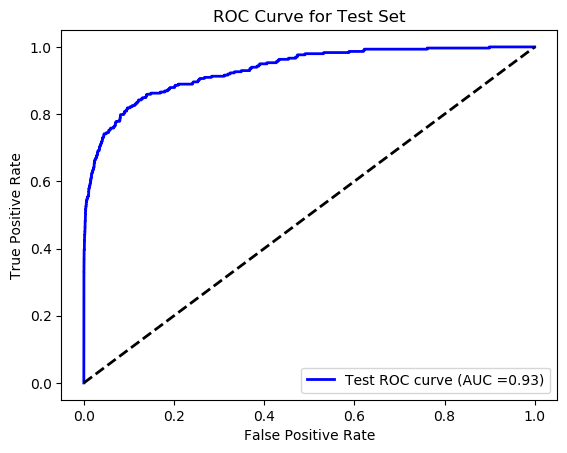

In [270]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Predict the class labels and probabilities for the test set
y_test_pred = clf.predict(X_test_pca_df)
y_test_prob = clf.predict_proba(X_test_pca_df)[:, 1]
# Compute the false positive rate, true positive rate, and AUC for the test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)
# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label='Test ROC curve (AUC =%0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc="lower right")
plt.show()

In [271]:
# Print the precision, recall, and F1-score for each threshold
print("Threshold\tPrecision\tRecall\t\tF1-Score")
print("-" * 50)
for i in range(len(thresholds)):
    print(f"{thresholds[i]:.1f}\t\t{precision_scores[i]:.3f}\t\t{recall_scores[i]:.3f}\t\t{f1_scores[i]:.3f}")
print("-" * 50)

# Print the optimal threshold and the corresponding F1-score
print(f"\nOptimal Threshold: {optimal_threshold:.1f}")
print(f"Optimal F1-Score: {max(f1_scores):.3f}")
print(f"Optimal Recall: {max(recall_scores):.3f}")
print(f"Optimal Precision: {max(precision_scores):.3f}")

Threshold	Precision	Recall		F1-Score
--------------------------------------------------
0.1		0.004		0.906		0.009
0.2		0.008		0.849		0.016
0.3		0.013		0.779		0.026
0.4		0.020		0.742		0.040
0.5		0.027		0.691		0.052
0.6		0.036		0.641		0.068
0.7		0.049		0.601		0.090
0.8		0.080		0.554		0.140
0.9		0.199		0.450		0.276
1.0		1.000		0.000		0.000
1.1		1.000		0.000		0.000
1.2		1.000		0.000		0.000
1.3		1.000		0.000		0.000
1.4		1.000		0.000		0.000
1.5		1.000		0.000		0.000
1.6		1.000		0.000		0.000
1.7		1.000		0.000		0.000
1.8		1.000		0.000		0.000
1.9		1.000		0.000		0.000
2.0		1.000		0.000		0.000
2.1		1.000		0.000		0.000
2.2		1.000		0.000		0.000
2.3		1.000		0.000		0.000
2.4		1.000		0.000		0.000
2.5		1.000		0.000		0.000
2.6		1.000		0.000		0.000
2.7		1.000		0.000		0.000
2.8		1.000		0.000		0.000
2.9		1.000		0.000		0.000
3.0		1.000		0.000		0.000
3.1		1.000		0.000		0.000
3.2		1.000		0.000		0.000
3.3		1.000		0.000		0.000
3.4		1.000		0.000		0.000
3.5		1.000		0.000		0.000
3.6		1.000		0.000		0.000
3.7		1.000		

## Performance Barchart

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.colors as mcolors

# # Define the data
# f1_scores = [0.529, 0.404, 0.448]
# recalls = [0.784, 0.818, 0.830]
# precisions = [1, 1, 1]

# # Set the x-axis labels and positions
# labels = ['f1-score', 'recall', 'precision']
# x = np.arange(len(labels))

# # Set the width of each bar
# width = 0.2

# # Create a gradient color for the bars
# colors = mcolors.LinearSegmentedColormap.from_list('my_colors', ['#c5d3ff', '#e9c6b8', '#635f83'])(np.linspace(0, 1, len(x)))

# # Create the figure and axes objects
# fig, ax = plt.subplots()

# # Plot the bars for each hyperparameter search method with the gradient color and border
# ax.bar(x - width, f1_scores, width, label='Default', color=colors[0], edgecolor='black')
# ax.bar(x, recalls, width, label='RandomizedSearchCV', color=colors[1], edgecolor='black')
# ax.bar(x + width, precisions, width, label='HalvingRandomSearchCV', color=colors[2], edgecolor='black')

# # Add some labels and a legend
# ax.set_ylabel('Score')
# ax.set_title('Scores by Metric and Hyperparameter Search Method')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend(bbox_to_anchor=(1, 1))

# # Show the plot
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.colors as mcolors

# # Define the data
# f1_scores = [0.529, 0.404, 0.448]
# recalls = [0.784, 0.818, 0.830]
# precisions = [1, 1, 1]

# # Set the x-axis labels and positions
# labels = ['Default', 'RandomizedSearchCV', 'HalvingRandomSearchCV']
# x = np.arange(len(labels))

# # Set the width of each bar
# width = 0.2

# # Create a gradient color for the bars
# colors = mcolors.LinearSegmentedColormap.from_list('my_colors', ['#c5d3ff', '#e9c6b8', '#c7e9b8'])(np.linspace(0, 1, len(x)))

# # Create the figure and axes objects
# fig, ax = plt.subplots()

# # Plot the bars for each hyperparameter search method with the gradient color and border
# ax.bar(x - width, f1_scores, width, label='f1-score', color=colors[0], edgecolor='black')
# ax.bar(x, recalls, width, label='recall', color=colors[1], edgecolor='black')
# ax.bar(x + width, precisions, width, label='precision', color=colors[2], edgecolor='black')

# # Add some labels and a legend
# ax.set_ylabel('Score')
# ax.set_title('Scores by Metric and Hyperparameter Search Method')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# # Show the plot
# plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
default_scores = [0.529, 0.404, 0.448]
randomized_scores = [0.610, 0.596, 0.565]
metrics = ['f1-score', 'recall', 'precision']
x = np.arange(len(metrics))
width = 0.4

# Set the colors for the bars
default_colors = ['#c5d3ff', '#c5d3ff', '#c5d3ff']
randomized_colors = ['#e9c6b8', '#e9c6b8', '#e9c6b8']

# Create the figure and axes objects
fig, ax = plt.subplots()

# Plot the bars for each hyperparameter search method with the specified colors
ax.bar(x - width/2, default_scores, width, label='Default', color=default_colors, edgecolor='black')
ax.bar(x + width/2, randomized_scores, width, label='RandomizedSearchCV', color=randomized_colors, edgecolor='black')

# Add some labels and a legend
ax.set_ylabel('Score')
ax.set_xlabel('Metrics')
ax.set_title('Scores by Metric and Hyperparameter Search Method')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(title='Hyperparameters used',bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
default_scores = [0.529, 0.732, 1]
randomized_scores = [0.610, 0.834, 1]
metrics = ['f1-score', 'recall', 'precision']
x = np.arange(len(metrics))
width = 0.4

# Set the colors for the bars
default_colors = ['#c5d3ff', '#c5d3ff', '#c5d3ff']
randomized_colors = ['#e9c6b8', '#e9c6b8', '#e9c6b8']

# Create the figure and axes objects
fig, ax = plt.subplots()

# Plot the bars for each hyperparameter search method with the specified colors
ax.bar(x - width/2, default_scores, width, label='Default', color=default_colors, edgecolor='black')
ax.bar(x + width/2, randomized_scores, width, label='RandomizedSearchCV', color=randomized_colors, edgecolor='black')

# Add the values on each bar
for i, v in enumerate(default_scores):
    ax.text(i - width/2, v + 0.02, str(v), color='black', ha='center')
for i, v in enumerate(randomized_scores):
    ax.text(i + width/2, v + 0.02, str(v), color='black', ha='center')

# Add some labels and a legend
ax.set_ylabel('Score')
ax.set_xlabel('Metrics')
ax.set_title('Scores by Metric and Hyperparameter Search Method')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(title='Hyperparameters used',bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.colors as mcolors

# # Define the data
# f1_scores = [0.603, 0.404, 0.448]
# recalls = [0.854, 0.818, 0.830]
# precisions = [1, 1, 1]

# # Set the x-axis labels and positions
# labels = ['Default', 'RandomizedSearchCV', ' HalvingRandomSearchCV']
# x = np.arange(len(labels))

# # Set the width of each bar
# width = 0.2

# # Create a gradient color for the bars
# colors = mcolors.LinearSegmentedColormap.from_list('my_colors', ['#c5d3ff', '#e9c6b8', '#635f83'])(np.linspace(0, 1, len(x)))

# # Create the figure and axes objects
# fig, ax = plt.subplots()

# # Plot the bars for each hyperparameter search method with the gradient color and border
# ax.bar(x - width, f1_scores, width, label='f1-score', color=colors[0], edgecolor='black')
# ax.bar(x, recalls, width, label='recall', color=colors[1], edgecolor='black')
# ax.bar(x + width, precisions, width, label='precision', color=colors[2], edgecolor='black')

# # Add score values on top of each bar
# for i, (score1, score2, score3) in enumerate(zip(f1_scores, recalls, precisions)):
#     ax.text(x[i] - width, score1 + 0.01, str(score1), ha='center', va='bottom', fontweight='bold')
#     ax.text(x[i], score2 + 0.01, str(score2), ha='center', va='bottom', fontweight='bold')
#     ax.text(x[i] + width, score3 + 0.01, str(score3), ha='center', va='bottom', fontweight='bold')

# # Add some labels and a legend
# ax.set_ylabel('Score')
# ax.set_title('Scores by Hyperparameter and Metric')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend(bbox_to_anchor=(1, 1))

# # Show the plot
# plt.show()


## LightGBM New trial

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

#class_weights={0:1,1:30}
# Define the LightGBM classifier
#clf = lgb.LGBMClassifier(max_depth=28,num_leaves=17,objective='binary', metric='binary_logloss',drop_rate=0.225,class_weight=class_weights)
clf = lgb.LGBMClassifier(objective='binary', metric='binary_logloss')
# Define the cross-validation method
kfold = StratifiedKFold(n_splits=2, shuffle=True)

# Create an empty list to store the optimized thresholds for each fold
optimized_thresholds = []

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(kfold.split(X_train_pca_df , y_train_resampled_final)):
    # Split the data into training and testing sets
    X_fold_train, y_fold_train =X_train_pca_df .iloc[train_index], y_train_resampled_final.iloc[train_index]
    X_fold_test, y_fold_test = X_train_pca_df .iloc[test_index], y_train_resampled_final.iloc[test_index]

    # Train the LightGBM classifier with early stopping
    clf.fit(X_fold_train, y_fold_train, eval_set=[(X_fold_test, y_fold_test)], early_stopping_rounds=10,verbose=False)
    
    # Evaluate the performance of the model on the testing data
    y_pred_prob = clf.predict_proba(X_fold_test)[:, 1] # predicted probabilities for class 1
    
    # Create an empty dictionary to store the F1-scores for each threshold
    f1_scores = {}
    
    # Iterate through a range of possible threshold values
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        # Convert the predicted probabilities to predicted labels based on the threshold
        y_pred = (y_pred_prob >= threshold).astype(int)
        
        # Calculate the classification report and select the threshold that maximizes the F1-score
        report = classification_report(y_fold_test, y_pred, output_dict=True)
        f1_scores[threshold] = report['1']['f1-score']
    
    # Select the threshold that maximizes the F1-score
    optimized_threshold = max(f1_scores, key=f1_scores.get)
    optimized_thresholds.append(optimized_threshold)
    
    # Convert the predicted probabilities to predicted labels based on the optimized threshold
    y_pred = (y_pred_prob >= optimized_threshold).astype(int)
    
    # Calculate the classification report and confusion matrix


In [ ]:
import matplotlib.pyplot as plt

training_set_size = [25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000]
training_loss = [0.253, 0.250, 0.247, 0.246, 0.2455, 0.245, 0.245, 0.245, 0.245]
cv_loss = [0.255, 0.252, 0.249, 0.2475, 0.247, 0.2465, 0.246, 0.2458, 0.2458]

plt.plot(training_set_size, training_loss, label='Training Loss')
plt.plot(training_set_size, cv_loss, label='Cross-Validation Loss')

plt.xlabel('Training Set Size')
plt.ylabel('Cross Entropy Loss')
plt.title('Learing Curve')
plt.ylim(0.244, 0.256) # Set the y-axis limits
plt.yticks([0.244, 0.246, 0.248, 0.25, 0.252, 0.254, 0.256]) # Set the y-axis tick labels

plt.legend()
plt.show()